In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset

dataset = load_dataset('emotion')

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [7]:
tweets, labels = get_tweets(train)

In [8]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something', 0)

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[10]]))

[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]


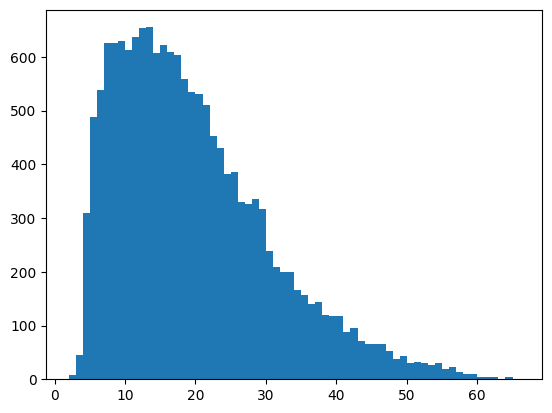

In [11]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=40, padding='post')
    return padded_sequences

In [15]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [17]:
padded_train_sequences[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [18]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


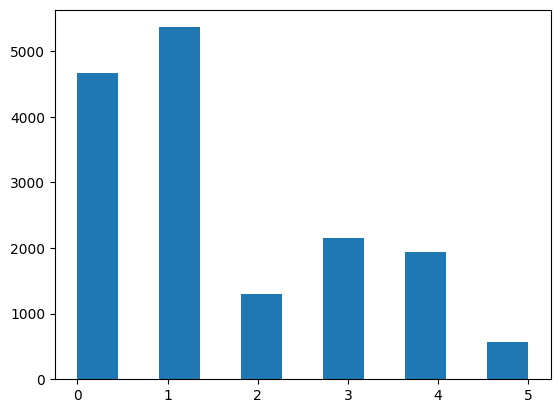

In [19]:
plt.hist(labels, bins=11)
plt.show()

In [20]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [21]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [22]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=40),
    tf.keras.layers.LSTM(64, return_sequences=True),  # first LSTM layer
    tf.keras.layers.LSTM(32),                          # second LSTM layer
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [25]:
val_tweets[20], val_labels[20]

('i just know to begin with i am going to feel shy about it', np.int64(4))

In [26]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3382 - loss: 1.5971 - val_accuracy: 0.3520 - val_loss: 1.5789
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3970 - loss: 1.4282 - val_accuracy: 0.6860 - val_loss: 0.9037
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7288 - loss: 0.8022 - val_accuracy: 0.8175 - val_loss: 0.6283
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8448 - loss: 0.5406 - val_accuracy: 0.8455 - val_loss: 0.5403
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8839 - loss: 0.4249 - val_accuracy: 0.8740 - val_loss: 0.4637
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9080 - loss: 0.3293 - val_accuracy: 0.8750 - val_loss: 0.4400
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9222 - loss: 0.2836 - val_accuracy: 0.8725 - val_loss: 0.4248
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9258 - loss: 0.2636 - val_accuracy: 0

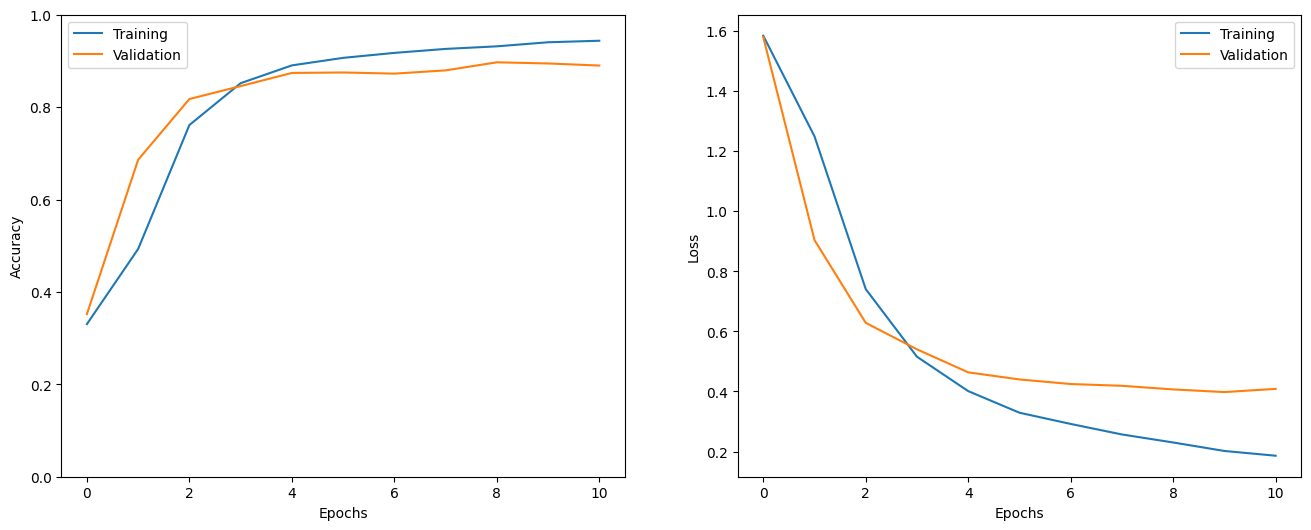

In [27]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [28]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [29]:
eval = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8849 - loss: 0.4225


In [30]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(test_sequences)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(test_labels)
print(type(y_pred))
print(type(y_true))


print(classification_report(y_true, y_pred, target_names=list(['0','1','2','3','4','5'])))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       581
           1       0.91      0.91      0.91       695
           2       0.72      0.74      0.73       159
           3       0.89      0.85      0.87       275
           4       0.81      0.95      0.87       224
           5       0.77      0.52      0.62        66

    accuracy                           0.88      2000
   macro avg       0.84      0.81      0.82      2000
weighted avg       0.88      0.88      0.88      2000



In [31]:
for a in range(0,5):
  i = random.randint(0, len(test_labels) - 1)

  print('Tweet:', test_tweets[i])
  print('Actual Emotion:', index_to_classes[test_labels[i]])

  p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]

  # Get the index of the predicted emotion
  predicted_emotion_index = np.argmax(p)

  print('Predicted Emotion:', index_to_classes.get(predicted_emotion_index), '\n')

Tweet: i also baked enough cookies to take to my local bbw tomorrow night i feel so bad for the employees who have to work
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Emotion: 0 

Tweet: i woke up yesterday monday morning feeling a little depressed
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Emotion: 0 

Tweet: i feel gloomy and tired
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Emotion: 0 

Tweet: i cant tell you how many times in the four months we have been seeing each other seriously that we have had to have serious emotional talks because one or both of us was feeling tender
Actual Emotion: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Emotion: 0 

Tweet: i was feeling disheartened when going on dates because i didn t feel i was meeting anyone i clicked with or would consider a long term relationship with
Actual Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Emotion: 0 

